# Kenteken OCR
Dit notebook is bedoeld voor het uitlezen van de kentekenplaten. Het notebook is af in de zin dat men kenteken detectie + uitlezing kan uitvoeren. Het uitlezen echter is momenteel vrij inaccuraat. 

In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
from mrcnn.model import mold_image
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract
from Utility.ImageProcessing import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# Change path to your own tesseract installation.
# Tesseract installation: https://github.com/tesseract-ocr/tesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

11:1: F403 'from Utility.ImageProcessing import *' used; unable to detect undefined names
13:41: W291 trailing whitespace
14:1: E402 module level import not at top of file
17:80: E501 line too long (87 > 79 characters)


# Model Inladen

In [6]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "plate_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [8]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_plate_cfg_0100.h5', by_name=True)

# Kenteken Detectie
functie voor het eenmalig detecteren van kentekens. 

In [9]:
def predict_once(img, model, cfg):
    """
    :param img: path to the image we want to detect plates on
    :param model: license plate detection model
    :param cfg: configuration for the model
    :type img: string
    :type model: .h5 file
    :type cfg: PredictionConfig
    :return boxes: detected bounding boxes
    :return image: the img
    :rtype boxes: list
    :rtype image: image
    """
    # load image and mask
    image = cv2.imread(img)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]
    # define subplot
    # plot raw pixel data
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Predicted')
    ax = plt.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the figure
    plt.show()
    return yhat['rois'], image

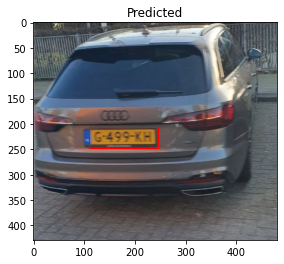

1:80: E501 line too long (106 > 79 characters)


In [104]:
boxes, img = predict_once(r"C:\Users\midni\Desktop\School\INNO\opencv-anpr\license_plates\group3\026.jpg",
                          model, cfg)

# Croppen
De gedecteerde kentekenplaat/kentekenplaten worden in dit gedeelte uit de foto gesneden.

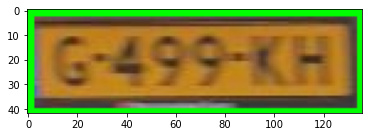

In [105]:
first_c = first_crops(img, boxes)
plt.imshow(cv2.cvtColor(first_c[0], cv2.COLOR_BGR2RGB))

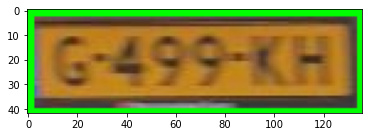

In [106]:
second_crop = secondCrop(first_c[0])
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))

# WIP SECTION

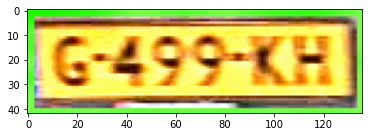

2:80: E501 line too long (87 > 79 characters)


In [107]:
contrasted_img = increase_contrast_2(increase_contrast_1(second_crop))
contrasted_img = apply_brightness_contrast(contrasted_img, brightness=-50, contrast=30)
plt.imshow(cv2.cvtColor(contrasted_img, cv2.COLOR_BGR2RGB))

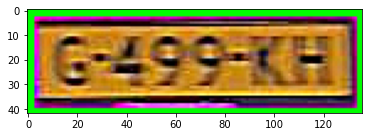

In [108]:
t = unsharp_mask(second_crop, amount=3.0, threshold=0, sigma=20.0)
plt.imshow(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))

# Bepaling Threshold
Eigen tests op foto's: <br>
foto 1: 5, 7, 12, 13 <br>
foto 2: 10, 13, 14 <br>
foto 3: 3, 6 <br>
foto 4: 3, 12 <br>
foto 5: 12 <br>
foto 6: 11, 17 <br>
foto 7: 1, 4, 5, 7 <br>
foto 8: 2, 14 <br>
foto 9: 4, 16 <br> 

In [109]:
pic1 = [5, 7, 12, 13]
pic2 = [10, 13, 14]
pic3 = [3, 6]
pic4 = [3, 12]
pic5 = [12]
pic6 = [11, 17]
pic7 = [1, 4, 5, 7]
pic8 = [2, 14]
pic9 = [4, 16]

all_pics = [pic1, pic2, pic3, pic4, pic5, pic6, pic7, pic8, pic9]
minimum = []
maximum = []
for pic in all_pics:
    minimum.append(min(pic))
    maximum.append(max(pic))
print("minimum="+str(np.median(minimum)), "maximum="+str(np.median(maximum)))

minimum=4.0 maximum=13.0


In [110]:
def test(img):
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print(thresh)
    counter = 0 
    for i in range(20, 70, 5):
        im_bw = cv2.threshold(im_gray, thresh+i, 255, cv2.THRESH_BINARY)

        plate_crop = Image.fromarray(im_bw[1])
        new_size = tuple(14*x for x in plate_crop.size)
        resized_img = plate_crop.resize(new_size, Image.ANTIALIAS)

        open_cv_image = np.array(resized_img)
        #resized_img = unsharp_mask(open_cv_image, amount=1.0, threshold=0, sigma=10)

        text = pytesseract.image_to_string(resized_img, config='--psm 10')
        print("Detected license plate Number is:", text+" Iteration= "+str(counter))
        counter+= 1
    return resized_img

3:80: E501 line too long (91 > 79 characters)
5:16: W291 trailing whitespace
13:9: F841 local variable 'open_cv_image' is assigned to but never used
14:9: E265 block comment should start with '# '
14:80: E501 line too long (85 > 79 characters)
17:80: E501 line too long (84 > 79 characters)
18:16: E225 missing whitespace around operator


153.0
Detected license plate Number is: G-459-KE |
 Iteration= 0
Detected license plate Number is: 'G-499-KE |
 Iteration= 1
Detected license plate Number is: 'G-499-KH|
 Iteration= 2
Detected license plate Number is: G49SKH
 Iteration= 3
Detected license plate Number is: G-499-KH |
 Iteration= 4
Detected license plate Number is: G-49S-KH |
 Iteration= 5
Detected license plate Number is: 4994
 Iteration= 6
Detected license plate Number is: £99
 Iteration= 7
Detected license plate Number is: GATSEH
 Iteration= 8
Detected license plate Number is: G-499-KH
 Iteration= 9


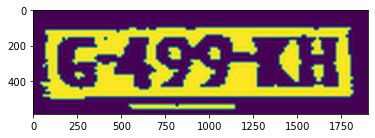

In [111]:
test_img = test(contrasted_img)
open_cv_image = np.array(test_img)
# Convert RGB to BGR
test_img = unsharp_mask(open_cv_image, amount=1.0, threshold=0, sigma=10)

plt.imshow(test_img)

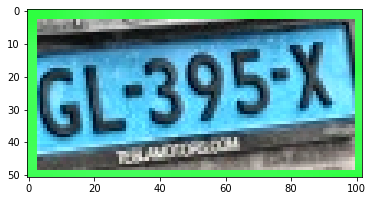

In [352]:
contrast1 = increase_contrast_1(second_crop)
plt.imshow(contrast1)

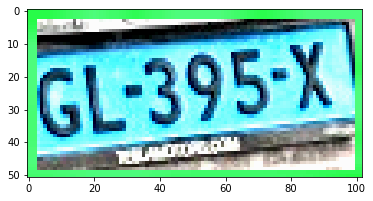

In [353]:
contrast2 = increase_contrast_2(contrast1)
contrast2 = apply_brightness_contrast(contrast2, brightness=-50, contrast=30)
plt.imshow(contrast2)

# Kenteken Uitlezen
In dit gedeelte wordt Tesseract gebruikt voor het uitlezen van de uitgesneden kenteken foto's. Dit gedeelte is nog niet af, omdat Tesseract nog gefinetuned moet worden. 

In [325]:
# Read the number plate
text = pytesseract.image_to_string(contrast3, config='--psm 8')
print("Detected license plate Number is:", text)

Detected license plate Number is: EX FE



In [250]:
plate_crop = Image.fromarray(second_crop)
new_size = tuple(14*x for x in contrast3.size)
resized_img = contrast3.resize(new_size, Image.ANTIALIAS)

In [251]:
resized_img = resized_img.filter(ImageFilter.SHARPEN)

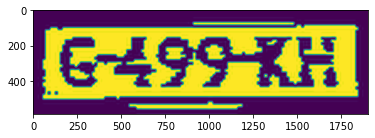

In [252]:
plt.imshow(resized_img)

In [253]:
# Read the number plate
text = pytesseract.image_to_string(resized_img, config='--psm 8')
print("Detected license plate Number is:", text)

Detected license plate Number is: LG-A9S-KH |



# Bronnen
Brownlee, J. (2020, September 1). How to Train an Object Detection Model with Keras. Machine Learning Mastery. https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

Matterport, M. (2018, March 20). matterport/Mask_RCNN. GitHub. https://github.com/matterport/Mask_RCNN

Theophilebuyssens, T. (2020, January 28). License Plate Recognition using OpenCV, YOLO and Keras. Medium. https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65